Group nodes into clusters based on their similarity or structural roles in the graph.

Train a GNN to embed nodes into a latent space, then apply clustering algorithms (e.g., K-Means) to the embeddings.

In [1]:
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GATConv, TopKPooling, global_mean_pool as gap, global_max_pool as gmp
import torch_geometric.nn
from torch_geometric.loader import DataLoader
from torch.optim import Adam
from sklearn.metrics import accuracy_score
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops


/Applications/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/Applications/anaconda3/lib/python3.11/site-packages/torch_sparse/_convert_cpu.so, 0x0006): symbol not found in flat namespace '__ZN2at8internal15invoke_parallelExxxRKNSt3__18functionIFvxxEEE'
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
node_features = pd.read_csv('preprocessed_node_features.csv')

/var/folders/9m/5shl5b5577q1b4pkqshrp5980000gn/T/ipykernel_1827/3506719987.py:1: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,25

In [3]:
edge_features = pd.read_csv('preprocessed_edge_features.csv')

In [4]:
node_features_numeric = node_features.select_dtypes(include=['number', 'bool'])  # Include numeric and boolean columns

if 'root_id' in node_features_numeric.columns:
    node_features_numeric = node_features_numeric.drop(columns=['root_id'])



In [5]:
node_features_tensor = torch.tensor(node_features_numeric.values, dtype=torch.float)

In [6]:
id_to_index = {root_id: idx for idx, root_id in enumerate(node_features['root_id'])} # PyTorch Geometric GNN works with nodes referenced by integer indices not arbitrary IDs

edge_features['pre_root_id'] = edge_features['pre_root_id'].map(id_to_index)
edge_features['post_root_id'] = edge_features['post_root_id'].map(id_to_index)

# Remove rows with unmapped IDs
edge_features = edge_features.dropna(subset=['pre_root_id', 'post_root_id']).astype({'pre_root_id': int, 'post_root_id': int})

edge_index = torch.tensor(edge_features[['pre_root_id', 'post_root_id']].values.T, dtype=torch.long) # standard edge representation used in PyTorch Geometric


In [7]:
labels = torch.tensor(node_features['nt_type'].factorize()[0], dtype=torch.long)

In [8]:
data = Data(
    x=node_features_tensor,
    edge_index=edge_index
)

In [9]:
data.y = torch.tensor(labels, dtype=torch.long) # true labels

/var/folders/9m/5shl5b5577q1b4pkqshrp5980000gn/T/ipykernel_1827/2186120499.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.y = torch.tensor(labels, dtype=torch.long) # true labels


In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

# Extract node features
node_features = data.x  # Node feature matrix


In [12]:
class NodeEmbeddingGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NodeEmbeddingGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

# Initialize the model
input_dim = node_features.shape[1]
hidden_dim = 64
output_dim = 32  # Dimensionality of the embeddings

model = NodeEmbeddingGNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [13]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    embeddings = model(data.x, data.edge_index)  # Generate node embeddings
    loss = torch.mean(embeddings.norm(dim=1))  # Optional: Regularization loss
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 517.4913
Epoch 2, Loss: 250.5259
Epoch 3, Loss: 141.5147
Epoch 4, Loss: 122.3558
Epoch 5, Loss: 95.6539
Epoch 6, Loss: 70.5934
Epoch 7, Loss: 65.9878
Epoch 8, Loss: 50.5319
Epoch 9, Loss: 35.7367
Epoch 10, Loss: 30.3412
Epoch 11, Loss: 23.7290
Epoch 12, Loss: 11.7376
Epoch 13, Loss: 2.4576
Epoch 14, Loss: 0.5889
Epoch 15, Loss: 0.1484
Epoch 16, Loss: 0.3881
Epoch 17, Loss: 0.1157
Epoch 18, Loss: 0.0993
Epoch 19, Loss: 0.0814
Epoch 20, Loss: 0.0637
Epoch 21, Loss: 0.0487
Epoch 22, Loss: 0.0400
Epoch 23, Loss: 0.0396
Epoch 24, Loss: 0.0440
Epoch 25, Loss: 0.0485
Epoch 26, Loss: 0.0508
Epoch 27, Loss: 0.0503
Epoch 28, Loss: 0.0472
Epoch 29, Loss: 0.0418
Epoch 30, Loss: 0.0350
Epoch 31, Loss: 0.0279
Epoch 32, Loss: 0.0222
Epoch 33, Loss: 0.0203
Epoch 34, Loss: 0.0223
Epoch 35, Loss: 0.0253
Epoch 36, Loss: 0.0266
Epoch 37, Loss: 0.0251
Epoch 38, Loss: 0.0210
Epoch 39, Loss: 0.0157
Epoch 40, Loss: 0.0130
Epoch 41, Loss: 0.0141
Epoch 42, Loss: 0.0152
Epoch 43, Loss: 0.0152
Epoc

In [20]:
model.eval()
with torch.no_grad():
    node_embeddings = model(data.x, data.edge_index).cpu().numpy()

#  KMeans clustering
num_clusters = 5  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
predicted_clusters = kmeans.fit_predict(node_embeddings)


In [21]:
true_labels = data.y.cpu().numpy()
ari = adjusted_rand_score(true_labels, predicted_clusters)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

Adjusted Rand Index (ARI): 0.0002


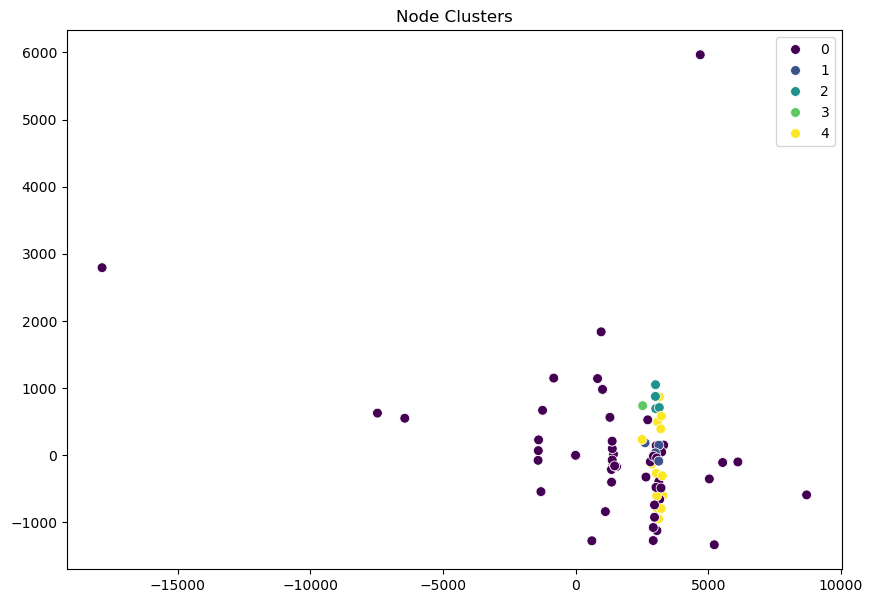

In [23]:
from sklearn.manifold import TSNE

# Reduce dimensionality for visual
tsne = TSNE(n_components=2, random_state=42)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

# Plot clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=node_embeddings_2d[:, 0], y=node_embeddings_2d[:, 1], hue=predicted_clusters, palette='viridis', s=50)
plt.title('Node Clusters')
plt.savefig('community_detection.png')
plt.show()


Nodes are color-coded based on their predicted cluster labels from KMeans. Nodes with the same color are grouped into the same cluster, suggesting that they belong to the same community based on their embedding.

Nodes that are close together in the plot belong to the same cluster in the embedding space.

If clusters overlap, it may indicate:
- Ambiguity in the data.
- Nodes that belong to multiple communities.
- Insufficient separation in the embedding space.
- Possible need for more expressive models